# Home Credit

In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import  RFE, RFECV, SelectFromModel
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score, auc, roc_curve
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
import time 
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Classes and Functions

In [2]:
class FeatureSelectionExecuter(BaseEstimator,TransformerMixin):
    def __init__(self,instclass,withy):
        self.a=instclass
        self.b=withy
        
    def fit(self,X,y,*_):
        if self.b == "No":
            self.a.fit(X)
        else:
            self.a.fit(X,y)
        return self
    
    def transform(self,Z,*_): 
        return pd.DataFrame(self.a.transform(Z), columns=Z.columns[self.a.get_support()])

In [3]:
def modelmetrics(name,y_pred,y_pred_proba,y_real,time_model):
    
    df_score = pd.concat([pd.DataFrame(data=y_pred_proba[:,1], columns=['score']),
                       pd.DataFrame(data=y_real)], axis=1)
    df_score = df_score.sort_values('score',ascending=False).reset_index(drop=True)
    df_score['bin'] = pd.qcut(df_score.index, 8)
    score = df_score.groupby(by='bin').agg({'score':{'score_min':min,'score_max':max}, 'TARGET':{'bads':sum,'total':'count'}})
    score=score.reset_index(level=0, col_fill='bin')
    score.columns = score.columns.droplevel(level=0)
    score['goods']=score['total']-score['bads']
    score['bad_rate']=score['bads']/score['total']
    score['bads_cum']=score['bads'].cumsum()
    score['goods_cum']=score['goods'].cumsum()
    score['total_cum']=score['total'].cumsum()
    score['bads_cum_rate']=score['bads_cum']/score['bads'].sum()
    score['goods_cum_rate']=score['goods_cum']/score['goods'].sum()
    score['total_cum_rate']=score['total_cum']/score['total'].sum()
    score['KS']=score['bads_cum_rate']-score['goods_cum_rate']
    ks=score['KS'].max()
    
    cm = confusion_matrix(y_real, y_pred)
    fpr,tpr,umbral = roc_curve(y_real, y_pred_proba[:,1])
    d = {'TP':cm[1][1],
         'TN':cm[0][0],
         'FP':cm[0][1],
         'FN':cm[1][0],
         'Accuracy':accuracy_score(y_real, y_pred),
         'Recall':recall_score(y_real, y_pred),
         'Precision':precision_score(y_real, y_pred),
         'F1':f1_score(y_real, y_pred),
         'AUC':auc(fpr,tpr),
         'Gini':2*auc(fpr,tpr)-1,
         'KS':ks, 
         'Minutes':time_model}
    df = pd.DataFrame(d, index=[name])
    df=df.reindex(columns=['TP','TN','FP','FN','Accuracy','Recall','Precision','F1','AUC','Gini','KS','Minutes'])
    
    return score, df

## Step 3: Models

In [4]:
# Import data sets
X_train_2 = pd.read_csv('X_train_2.csv', index_col=0)
X_test_2 = pd.read_csv('X_test_2.csv', index_col=0)
y_train_2 = pd.read_csv('y_train_2.csv', header=None)
y_test_2 = pd.read_csv('y_test_2.csv', header=None)

y_train_2 = y_train_2.drop(columns=0).rename(columns={1:'TARGET'})
y_test_2 = y_test_2.drop(columns=0).rename(columns={1:'TARGET'})

display(X_train_2.shape, X_test_2.shape, y_train_2.shape, y_test_2.shape)

(246008, 187)

(61502, 187)

(246008, 1)

(61502, 1)

In [5]:
model_compare = pd.DataFrame()

## 1. Logistic Regression

### 1.1 Logistic Regression (NO FS NO SM)

In [6]:
model_pipeline_LR = make_pipeline(LogisticRegression())

In [7]:
start = time.time()

model_pipeline_LR.fit(X_train_2,y_train_2)
y_pred = model_pipeline_LR.predict(X_test_2)
y_pred_proba = model_pipeline_LR.predict_proba(X_test_2)

end = time.time()
time_model=end-start
time_model=time_model/60

score_LR, df_LR = modelmetrics('LogisticRegression', y_pred, y_pred_proba, y_test_2,time_model) 

model_compare= pd.concat([model_compare,df_LR])
model_compare_LR = model_compare

display(model_compare, score_LR)

,TP,TN,FP,FN,Accuracy,Recall,Precision,F1,AUC,Gini,KS,Minutes
LogisticRegression,36,56497,40,4929,0.919206,0.007251,0.473684,0.014283,0.741644,0.483288,0.361981,0.131119


,bin,score_min,score_max,bads,total,goods,bad_rate,bads_cum,goods_cum,total_cum,bads_cum_rate,goods_cum_rate,total_cum_rate,KS
0,"(-0.001, 7687.625]",0.154064,0.672522,1748,7688,5940,0.227367,1748,5940,7688,0.352064,0.105064,0.125004,0.247001
1,"(7687.625, 15375.25]",0.102452,0.154051,1035,7688,6653,0.134625,2783,12593,15376,0.560524,0.222739,0.250008,0.337785
2,"(15375.25, 23062.875]",0.075157,0.102446,731,7687,6956,0.095096,3514,19549,23063,0.707754,0.345774,0.374996,0.361981
3,"(23062.875, 30750.5]",0.057100,0.075156,495,7688,7193,0.064386,4009,26742,30751,0.807452,0.473000,0.500000,0.334452
4,"(30750.5, 38438.125]",0.043729,0.057098,368,7688,7320,0.047867,4377,34062,38439,0.881571,0.602473,0.625004,0.279098
5,"(38438.125, 46125.75]",0.032831,0.043729,291,7687,7396,0.037856,4668,41458,46126,0.940181,0.733290,0.749992,0.206892
6,"(46125.75, 53813.375]",0.022683,0.032829,186,7688,7502,0.024194,4854,48960,53814,0.977644,0.865982,0.874996,0.111662
7,"(53813.375, 61501.0]",0.001559,0.022682,111,7688,7577,0.014438,4965,56537,61502,1.000000,1.000000,1.000000,0.000000


### 1.2 Logistic Regression with feature selection RFE

In [8]:
feature_selection_LR_RFE_pipeline = make_pipeline(FeatureSelectionExecuter(RFE(LogisticRegression(max_iter = 1000),n_features_to_select=120),"Yes"))
model_pipeline_LR_RFE = make_pipeline(LogisticRegression())

In [9]:
start = time.time()

X_train_2_fs = feature_selection_LR_RFE_pipeline.fit_transform(X_train_2,y_train_2)
X_test_2_fs = feature_selection_LR_RFE_pipeline.transform(X_test_2)


model_pipeline_LR_RFE.fit(X_train_2_fs,y_train_2)
y_pred = model_pipeline_LR_RFE.predict(X_test_2_fs)
y_pred_proba = model_pipeline_LR_RFE.predict_proba(X_test_2_fs)

end = time.time()
time_model=end-start
time_model=time_model/60

score_LR_RFE, df_LR_RFE = modelmetrics('LogisticRegression RFE', y_pred, y_pred_proba, y_test_2,time_model) 

model_compare=pd.concat([model_compare,df_LR_RFE])
model_compare_LR_RFE = model_compare

display(model_compare, score_LR_RFE)

,TP,TN,FP,FN,Accuracy,Recall,Precision,F1,AUC,Gini,KS,Minutes
LogisticRegression,36,56497,40,4929,0.919206,0.007251,0.473684,0.014283,0.741644,0.483288,0.361981,0.131119
LogisticRegression RFE,37,56499,38,4928,0.919255,0.007452,0.493333,0.014683,0.742399,0.484797,0.365048,41.746602


,bin,score_min,score_max,bads,total,goods,bad_rate,bads_cum,goods_cum,total_cum,bads_cum_rate,goods_cum_rate,total_cum_rate,KS
0,"(-0.001, 7687.625]",0.153295,0.672430,1757,7688,5931,0.228538,1757,5931,7688,0.353877,0.104905,0.125004,0.248972
1,"(7687.625, 15375.25]",0.102078,0.153291,1053,7688,6635,0.136967,2810,12566,15376,0.565962,0.222262,0.250008,0.343700
2,"(15375.25, 23062.875]",0.074640,0.102069,718,7687,6969,0.093404,3528,19535,23063,0.710574,0.345526,0.374996,0.365048
3,"(23062.875, 30750.5]",0.056749,0.074638,487,7688,7201,0.063345,4015,26736,30751,0.808661,0.472894,0.500000,0.335767
4,"(30750.5, 38438.125]",0.043495,0.056748,369,7688,7319,0.047997,4384,34055,38439,0.882981,0.602349,0.625004,0.280632
5,"(38438.125, 46125.75]",0.032807,0.043495,268,7687,7419,0.034864,4652,41474,46126,0.936959,0.733573,0.749992,0.203386
6,"(46125.75, 53813.375]",0.022691,0.032806,200,7688,7488,0.026015,4852,48962,53814,0.977241,0.866017,0.874996,0.111224
7,"(53813.375, 61501.0]",0.001805,0.022689,113,7688,7575,0.014698,4965,56537,61502,1.000000,1.000000,1.000000,0.000000


### 1.3 Logistic Regression with feature selection RFECV

In [10]:
kf=KFold(n_splits=3, shuffle=True, random_state=1234)
feature_selection_LR_RFECV_pipeline = make_pipeline(FeatureSelectionExecuter
                                                    (RFECV(LogisticRegression(max_iter = 4000),
                                                    cv=kf,scoring='neg_mean_squared_error')
                                                     ,"Yes"))
model_pipeline_LR_RFECV = make_pipeline(LogisticRegression())

In [11]:
start = time.time()

X_train_2_fs = feature_selection_LR_RFECV_pipeline.fit_transform(X_train_2,y_train_2)
X_test_2_fs = feature_selection_LR_RFECV_pipeline.transform(X_test_2)


model_pipeline_LR_RFECV.fit(X_train_2_fs,y_train_2)
y_pred = model_pipeline_LR_RFECV.predict(X_test_2_fs)
y_pred_proba = model_pipeline_LR_RFECV.predict_proba(X_test_2_fs)

end = time.time()
time_model=end-start
time_model=time_model/60

score_LR_RFECV, df_LR_RFECV = modelmetrics('LogisticRegression RFECV', y_pred, y_pred_proba, y_test_2,time_model) 

model_compare=pd.concat([model_compare,df_LR_RFECV])
model_compare_LR_RFECV = model_compare

display(model_compare, score_LR_RFECV)

,TP,TN,FP,FN,Accuracy,Recall,Precision,F1,AUC,Gini,KS,Minutes
LogisticRegression,36,56497,40,4929,0.919206,0.007251,0.473684,0.014283,0.741644,0.483288,0.361981,0.131119
LogisticRegression RFE,37,56499,38,4928,0.919255,0.007452,0.493333,0.014683,0.742399,0.484797,0.365048,41.746602
LogisticRegression RFECV,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.539789,0.079578,0.093007,189.196640


,bin,score_min,score_max,bads,total,goods,bad_rate,bads_cum,goods_cum,total_cum,bads_cum_rate,goods_cum_rate,total_cum_rate,KS
0,"(-0.001, 7687.625]",0.091610,0.096346,578,7688,7110,0.075182,578,7110,7688,0.116415,0.125758,0.125004,-0.009343
1,"(7687.625, 15375.25]",0.089624,0.091610,669,7688,7019,0.087019,1247,14129,15376,0.251158,0.249907,0.250008,0.001251
2,"(15375.25, 23062.875]",0.086205,0.089624,665,7687,7022,0.086510,1912,21151,23063,0.385096,0.374109,0.374996,0.010987
3,"(23062.875, 30750.5]",0.082764,0.086205,995,7688,6693,0.129422,2907,27844,30751,0.585498,0.492492,0.500000,0.093007
4,"(30750.5, 38438.125]",0.079042,0.082764,577,7688,7111,0.075052,3484,34955,38439,0.701712,0.618268,0.625004,0.083444
5,"(38438.125, 46125.75]",0.075863,0.079042,641,7687,7046,0.083388,4125,42001,46126,0.830816,0.742894,0.749992,0.087922
6,"(46125.75, 53813.375]",0.069135,0.075863,468,7688,7220,0.060874,4593,49221,53814,0.925076,0.870598,0.874996,0.054478
7,"(53813.375, 61501.0]",0.020063,0.069135,372,7688,7316,0.048387,4965,56537,61502,1.000000,1.000000,1.000000,0.000000


### 1.4 Logistic Regression with SMOTE

In [12]:
#smote is not in a pipeline
smote= SMOTE(random_state=101)
model_pipeline_LR_SM = make_pipeline(LogisticRegression(max_iter = 4000))

In [13]:
start = time.time()

X_train_2_sm, y_train_2_sm = smote.fit_sample(X_train_2, y_train_2)

model_pipeline_LR_SM.fit(X_train_2_sm,y_train_2_sm)
y_pred = model_pipeline_LR_SM.predict(X_test_2)
y_pred_proba = model_pipeline_LR_SM.predict_proba(X_test_2)

end = time.time()
time_model=end-start
time_model=time_model/60

score_LR_SM, df_LR_SM = modelmetrics('LogisticRegression SM', y_pred, y_pred_proba, y_test_2,time_model) 

model_compare= pd.concat([model_compare,df_LR_SM])
model_compare_LR_SM = model_compare

display(model_compare, score_LR_SM)

,TP,TN,FP,FN,Accuracy,Recall,Precision,F1,AUC,Gini,KS,Minutes
LogisticRegression,36,56497,40,4929,0.919206,0.007251,0.473684,0.014283,0.741644,0.483288,0.361981,0.131119
LogisticRegression RFE,37,56499,38,4928,0.919255,0.007452,0.493333,0.014683,0.742399,0.484797,0.365048,41.746602
LogisticRegression RFECV,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.539789,0.079578,0.093007,189.196640
LogisticRegression SM,3226,39654,16883,1739,0.697213,0.649748,0.160426,0.257318,0.735386,0.470772,0.347739,3.915135


,bin,score_min,score_max,bads,total,goods,bad_rate,bads_cum,goods_cum,total_cum,bads_cum_rate,goods_cum_rate,total_cum_rate,KS
0,"(-0.001, 7687.625]",0.700416,0.975826,1734,7688,5954,0.225546,1734,5954,7688,0.349245,0.105312,0.125004,0.243933
1,"(7687.625, 15375.25]",0.568157,0.700416,1046,7688,6642,0.136056,2780,12596,15376,0.559919,0.222792,0.250008,0.337127
2,"(15375.25, 23062.875]",0.462324,0.568145,669,7687,7018,0.087030,3449,19614,23063,0.694663,0.346923,0.374996,0.347739
3,"(23062.875, 30750.5]",0.372843,0.462319,526,7688,7162,0.068418,3975,26776,30751,0.800604,0.473601,0.500000,0.327003
4,"(30750.5, 38438.125]",0.294713,0.372820,361,7688,7327,0.046956,4336,34103,38439,0.873313,0.603198,0.625004,0.270115
5,"(38438.125, 46125.75]",0.222318,0.294694,286,7687,7401,0.037206,4622,41504,46126,0.930916,0.734103,0.749992,0.196813
6,"(46125.75, 53813.375]",0.147586,0.222304,214,7688,7474,0.027836,4836,48978,53814,0.974018,0.866300,0.874996,0.107718
7,"(53813.375, 61501.0]",0.004996,0.147584,129,7688,7559,0.016779,4965,56537,61502,1.000000,1.000000,1.000000,0.000000


## 2. Naive Bayes

### 2.1 Naive Bayes (NO FS NO SM)

In [14]:
model_pipeline_NB = make_pipeline(MultinomialNB())

In [15]:
start = time.time()

model_pipeline_NB.fit(X_train_2,y_train_2)
y_pred = model_pipeline_NB.predict(X_test_2)
y_pred_proba = model_pipeline_NB.predict_proba(X_test_2)

end = time.time()
time_model=end-start
time_model=time_model/60

score_NB, df_NB = modelmetrics('NaiveBayes', y_pred, y_pred_proba, y_test_2,time_model) 

model_compare= pd.concat([model_compare,df_NB])
model_compare_NB = model_compare

display(model_compare, score_NB)

,TP,TN,FP,FN,Accuracy,Recall,Precision,F1,AUC,Gini,KS,Minutes
LogisticRegression,36,56497,40,4929,0.919206,0.007251,0.473684,0.014283,0.741644,0.483288,0.361981,0.131119
LogisticRegression RFE,37,56499,38,4928,0.919255,0.007452,0.493333,0.014683,0.742399,0.484797,0.365048,41.746602
LogisticRegression RFECV,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.539789,0.079578,0.093007,189.196640
LogisticRegression SM,3226,39654,16883,1739,0.697213,0.649748,0.160426,0.257318,0.735386,0.470772,0.347739,3.915135
NaiveBayes,106,56141,396,4859,0.914556,0.021349,0.211155,0.038778,0.631575,0.263150,0.192399,0.004301


,bin,score_min,score_max,bads,total,goods,bad_rate,bads_cum,goods_cum,total_cum,bads_cum_rate,goods_cum_rate,total_cum_rate,KS
0,"(-0.001, 7687.625]",0.232875,0.755576,1165,7688,6523,0.151535,1165,6523,7688,0.234642,0.115376,0.125004,0.119267
1,"(7687.625, 15375.25]",0.147297,0.232863,846,7688,6842,0.110042,2011,13365,15376,0.405035,0.236394,0.250008,0.168641
2,"(15375.25, 23062.875]",0.097051,0.147285,729,7687,6958,0.094835,2740,20323,23063,0.551863,0.359464,0.374996,0.192399
3,"(23062.875, 30750.5]",0.064643,0.097038,600,7688,7088,0.078044,3340,27411,30751,0.672709,0.484833,0.500000,0.187876
4,"(30750.5, 38438.125]",0.041833,0.064643,529,7688,7159,0.068809,3869,34570,38439,0.779255,0.611458,0.625004,0.167797
5,"(38438.125, 46125.75]",0.026662,0.041829,436,7687,7251,0.056719,4305,41821,46126,0.867069,0.739710,0.749992,0.127359
6,"(46125.75, 53813.375]",0.015042,0.026661,364,7688,7324,0.047347,4669,49145,53814,0.940383,0.869254,0.874996,0.071129
7,"(53813.375, 61501.0]",0.000910,0.015042,296,7688,7392,0.038502,4965,56537,61502,1.000000,1.000000,1.000000,0.000000


### 2.2 Naive Bayes Feature Selection RFECV

#### scoring='neg_mean_squared_error'

In [16]:
kf=KFold(n_splits=3, shuffle=True, random_state=1234)
feature_selection_NB_RFECV_pipeline = make_pipeline(FeatureSelectionExecuter
                                                    (RFECV(MultinomialNB(),
                                                    cv=kf,scoring='neg_mean_squared_error')
                                                     ,"Yes"))
model_pipeline_NB_RFECV = make_pipeline(MultinomialNB())

In [17]:
start = time.time()

X_train_2_fs_NB = feature_selection_NB_RFECV_pipeline.fit_transform(X_train_2,y_train_2)
X_test_2_fs_NB = feature_selection_NB_RFECV_pipeline.transform(X_test_2)


model_pipeline_NB_RFECV.fit(X_train_2_fs_NB,y_train_2)
y_pred = model_pipeline_NB_RFECV.predict(X_test_2_fs_NB)
y_pred_proba = model_pipeline_NB_RFECV.predict_proba(X_test_2_fs_NB)

end = time.time()
time_model=end-start
time_model=time_model/60

score_NB_RFECV, df_NB_RFECV = modelmetrics('NaiveBayes RFECV SqError', y_pred, y_pred_proba, y_test_2,time_model) 

model_compare=pd.concat([model_compare,df_NB_RFECV])
model_compare_NB_RFECV = model_compare

display(model_compare, score_NB_RFECV)

,TP,TN,FP,FN,Accuracy,Recall,Precision,F1,AUC,Gini,KS,Minutes
LogisticRegression,36,56497,40,4929,0.919206,0.007251,0.473684,0.014283,0.741644,0.483288,0.361981,0.131119
LogisticRegression RFE,37,56499,38,4928,0.919255,0.007452,0.493333,0.014683,0.742399,0.484797,0.365048,41.746602
LogisticRegression RFECV,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.539789,0.079578,0.093007,189.196640
LogisticRegression SM,3226,39654,16883,1739,0.697213,0.649748,0.160426,0.257318,0.735386,0.470772,0.347739,3.915135
NaiveBayes,106,56141,396,4859,0.914556,0.021349,0.211155,0.038778,0.631575,0.263150,0.192399,0.004301
NaiveBayes RFECV SqError,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.500000,0.000000,0.008951,4.736567


,bin,score_min,score_max,bads,total,goods,bad_rate,bads_cum,goods_cum,total_cum,bads_cum_rate,goods_cum_rate,total_cum_rate,KS
0,"(-0.001, 7687.625]",0.080725,0.080725,650,7688,7038,0.084547,650,7038,7688,0.130916,0.124485,0.125004,0.006432
1,"(7687.625, 15375.25]",0.080725,0.080725,614,7688,7074,0.079865,1264,14112,15376,0.254582,0.249606,0.250008,0.004976
2,"(15375.25, 23062.875]",0.080725,0.080725,621,7687,7066,0.080786,1885,21178,23063,0.379658,0.374587,0.374996,0.005071
3,"(23062.875, 30750.5]",0.080725,0.080725,634,7688,7054,0.082466,2519,28232,30751,0.507351,0.499354,0.500000,0.007997
4,"(30750.5, 38438.125]",0.080725,0.080725,625,7688,7063,0.081296,3144,35295,38439,0.633233,0.624281,0.625004,0.008951
5,"(38438.125, 46125.75]",0.080725,0.080725,620,7687,7067,0.080656,3764,42362,46126,0.758107,0.749279,0.749992,0.008828
6,"(46125.75, 53813.375]",0.080725,0.080725,599,7688,7089,0.077914,4363,49451,53814,0.878751,0.874666,0.874996,0.004085
7,"(53813.375, 61501.0]",0.080725,0.080725,602,7688,7086,0.078304,4965,56537,61502,1.000000,1.000000,1.000000,0.000000


#### scoring='roc_auc'

In [18]:
kf=KFold(n_splits=3, shuffle=True, random_state=1234)
feature_selection_NB_RFECV_pipeline_2 = make_pipeline(FeatureSelectionExecuter
                                                    (RFECV(MultinomialNB(),
                                                    cv=kf,scoring='roc_auc')
                                                     ,"Yes"))
model_pipeline_NB_RFECV_2 = make_pipeline(MultinomialNB())

In [19]:
start = time.time()

X_train_2_fs_NB_2 = feature_selection_NB_RFECV_pipeline_2.fit_transform(X_train_2,y_train_2)
X_test_2_fs_NB_2 = feature_selection_NB_RFECV_pipeline_2.transform(X_test_2)


model_pipeline_NB_RFECV_2.fit(X_train_2_fs_NB_2,y_train_2)
y_pred = model_pipeline_NB_RFECV_2.predict(X_test_2_fs_NB_2)
y_pred_proba = model_pipeline_NB_RFECV_2.predict_proba(X_test_2_fs_NB_2)

end = time.time()
time_model=end-start
time_model=time_model/60

score_NB_RFECV_2, df_NB_RFECV_2 = modelmetrics('NaiveBayes RFECV AUC', y_pred, y_pred_proba, y_test_2,time_model) 

model_compare=pd.concat([model_compare,df_NB_RFECV_2])
model_compare_NB_RFECV_2 = model_compare

display(model_compare, score_NB_RFECV_2)

,TP,TN,FP,FN,Accuracy,Recall,Precision,F1,AUC,Gini,KS,Minutes
LogisticRegression,36,56497,40,4929,0.919206,0.007251,0.473684,0.014283,0.741644,0.483288,0.361981,0.131119
LogisticRegression RFE,37,56499,38,4928,0.919255,0.007452,0.493333,0.014683,0.742399,0.484797,0.365048,41.746602
LogisticRegression RFECV,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.539789,0.079578,0.093007,189.196640
LogisticRegression SM,3226,39654,16883,1739,0.697213,0.649748,0.160426,0.257318,0.735386,0.470772,0.347739,3.915135
NaiveBayes,106,56141,396,4859,0.914556,0.021349,0.211155,0.038778,0.631575,0.263150,0.192399,0.004301
NaiveBayes RFECV SqError,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.500000,0.000000,0.008951,4.736567
NaiveBayes RFECV AUC,97,56171,366,4868,0.914897,0.019537,0.209503,0.035741,0.631669,0.263338,0.192618,4.469134


,bin,score_min,score_max,bads,total,goods,bad_rate,bads_cum,goods_cum,total_cum,bads_cum_rate,goods_cum_rate,total_cum_rate,KS
0,"(-0.001, 7687.625]",0.229537,0.749538,1162,7688,6526,0.151145,1162,6526,7688,0.234038,0.115429,0.125004,0.118609
1,"(7687.625, 15375.25]",0.144882,0.229535,841,7688,6847,0.109391,2003,13373,15376,0.403424,0.236535,0.250008,0.166889
2,"(15375.25, 23062.875]",0.095348,0.144874,738,7687,6949,0.096006,2741,20322,23063,0.552064,0.359446,0.374996,0.192618
3,"(23062.875, 30750.5]",0.063433,0.095335,599,7688,7089,0.077914,3340,27411,30751,0.672709,0.484833,0.500000,0.187876
4,"(30750.5, 38438.125]",0.041741,0.063430,524,7688,7164,0.068158,3864,34575,38439,0.778248,0.611546,0.625004,0.166701
5,"(38438.125, 46125.75]",0.027432,0.041740,446,7687,7241,0.058020,4310,41816,46126,0.868077,0.739622,0.749992,0.128455
6,"(46125.75, 53813.375]",0.015729,0.027432,359,7688,7329,0.046696,4669,49145,53814,0.940383,0.869254,0.874996,0.071129
7,"(53813.375, 61501.0]",0.000943,0.015728,296,7688,7392,0.038502,4965,56537,61502,1.000000,1.000000,1.000000,0.000000


### 2.3 Naive Bayes SMOTE

In [20]:
#smote is not in a pipeline
smote= SMOTE(random_state=101)
model_pipeline_NB_SM = make_pipeline(MultinomialNB())

In [21]:
start = time.time()

X_train_2_sm, y_train_2_sm = smote.fit_sample(X_train_2, y_train_2)
#X_train_2_sm = pd.DataFrame(X_train_2_sm, columns=[X_train_2.columns])

model_pipeline_NB_SM.fit(X_train_2_sm,y_train_2_sm)
y_pred = model_pipeline_NB_SM.predict(X_test_2)
y_pred_proba = model_pipeline_NB_SM.predict_proba(X_test_2)

end = time.time()
time_model=end-start
time_model=time_model/60

score_NB_SM, df_NB_SM = modelmetrics('NaiveBayes SM', y_pred, y_pred_proba, y_test_2,time_model) 

model_compare= pd.concat([model_compare,df_NB_SM])
model_compare_NB_SM = model_compare

display(model_compare, score_NB_SM)

,TP,TN,FP,FN,Accuracy,Recall,Precision,F1,AUC,Gini,KS,Minutes
LogisticRegression,36,56497,40,4929,0.919206,0.007251,0.473684,0.014283,0.741644,0.483288,0.361981,0.131119
LogisticRegression RFE,37,56499,38,4928,0.919255,0.007452,0.493333,0.014683,0.742399,0.484797,0.365048,41.746602
LogisticRegression RFECV,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.539789,0.079578,0.093007,189.196640
LogisticRegression SM,3226,39654,16883,1739,0.697213,0.649748,0.160426,0.257318,0.735386,0.470772,0.347739,3.915135
NaiveBayes,106,56141,396,4859,0.914556,0.021349,0.211155,0.038778,0.631575,0.263150,0.192399,0.004301
NaiveBayes RFECV SqError,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.500000,0.000000,0.008951,4.736567
NaiveBayes RFECV AUC,97,56171,366,4868,0.914897,0.019537,0.209503,0.035741,0.631669,0.263338,0.192618,4.469134
NaiveBayes SM,2952,33496,23041,2013,0.592631,0.594562,0.113569,0.190710,0.631469,0.262938,0.187360,1.694798


,bin,score_min,score_max,bads,total,goods,bad_rate,bads_cum,goods_cum,total_cum,bads_cum_rate,goods_cum_rate,total_cum_rate,KS
0,"(-0.001, 7687.625]",0.778074,0.963686,1170,7688,6518,0.152185,1170,6518,7688,0.235650,0.115287,0.125004,0.120362
1,"(7687.625, 15375.25]",0.660266,0.778073,834,7688,6854,0.108481,2004,13372,15376,0.403625,0.236518,0.250008,0.167108
2,"(15375.25, 23062.875]",0.543583,0.660262,713,7687,6974,0.092754,2717,20346,23063,0.547231,0.359871,0.374996,0.187360
3,"(23062.875, 30750.5]",0.426721,0.543580,601,7688,7087,0.078174,3318,27433,30751,0.668278,0.485222,0.500000,0.183056
4,"(30750.5, 38438.125]",0.318736,0.426706,558,7688,7130,0.072581,3876,34563,38439,0.780665,0.611334,0.625004,0.169330
5,"(38438.125, 46125.75]",0.223065,0.318726,435,7687,7252,0.056589,4311,41815,46126,0.868278,0.739604,0.749992,0.128674
6,"(46125.75, 53813.375]",0.131906,0.223059,372,7688,7316,0.048387,4683,49131,53814,0.943202,0.869006,0.874996,0.074196
7,"(53813.375, 61501.0]",0.003129,0.131895,282,7688,7406,0.036681,4965,56537,61502,1.000000,1.000000,1.000000,0.000000


## 3. Tree Classifier

In [22]:
model_pipeline_TC = make_pipeline(GridSearchCV(DecisionTreeClassifier(random_state=110), 
                  {'max_depth':[5,10,15,30], 
                  'min_samples_leaf':[5,10,15]}, 
                  scoring='roc_auc', 
                  verbose=1 , 
                  n_jobs=-1))

In [23]:
start = time.time()

model_pipeline_TC.fit(X_train_2,y_train_2)
y_pred = model_pipeline_TC.predict(X_test_2)
y_pred_proba = model_pipeline_TC.predict_proba(X_test_2)

end = time.time()
time_model=end-start
time_model=time_model/60

best_model_TC=model_pipeline_TC.named_steps['gridsearchcv'].best_estimator_

score_TC, df_TC = modelmetrics('TreeClassifier AUC', y_pred, y_pred_proba, y_test_2,time_model) 

model_compare=pd.concat([model_compare,df_TC])
model_compare_TC = model_compare

display(model_compare, score_TC, best_model_TC)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.3min finished


,TP,TN,FP,FN,Accuracy,Recall,Precision,F1,AUC,Gini,KS,Minutes
LogisticRegression,36,56497,40,4929,0.919206,0.007251,0.473684,0.014283,0.741644,0.483288,0.361981,0.131119
LogisticRegression RFE,37,56499,38,4928,0.919255,0.007452,0.493333,0.014683,0.742399,0.484797,0.365048,41.746602
LogisticRegression RFECV,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.539789,0.079578,0.093007,189.196640
LogisticRegression SM,3226,39654,16883,1739,0.697213,0.649748,0.160426,0.257318,0.735386,0.470772,0.347739,3.915135
NaiveBayes,106,56141,396,4859,0.914556,0.021349,0.211155,0.038778,0.631575,0.263150,0.192399,0.004301
NaiveBayes RFECV SqError,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.500000,0.000000,0.008951,4.736567
NaiveBayes RFECV AUC,97,56171,366,4868,0.914897,0.019537,0.209503,0.035741,0.631669,0.263338,0.192618,4.469134
NaiveBayes SM,2952,33496,23041,2013,0.592631,0.594562,0.113569,0.190710,0.631469,0.262938,0.187360,1.694798
TreeClassifier AUC,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.724192,0.448385,0.336785,3.418094


,bin,score_min,score_max,bads,total,goods,bad_rate,bads_cum,goods_cum,total_cum,bads_cum_rate,goods_cum_rate,total_cum_rate,KS
0,"(-0.001, 7687.625]",0.163343,0.370109,1704,7688,5984,0.221644,1704,5984,7688,0.343202,0.105842,0.125004,0.237360
1,"(7687.625, 15375.25]",0.108174,0.163343,949,7688,6739,0.123439,2653,12723,15376,0.534340,0.225038,0.250008,0.309302
2,"(15375.25, 23062.875]",0.078892,0.108174,746,7687,6941,0.097047,3399,19664,23063,0.684592,0.347808,0.374996,0.336785
3,"(23062.875, 30750.5]",0.056797,0.078892,511,7688,7177,0.066467,3910,26841,30751,0.787513,0.474751,0.500000,0.312762
4,"(30750.5, 38438.125]",0.044787,0.056797,373,7688,7315,0.048517,4283,34156,38439,0.862638,0.604135,0.625004,0.258503
5,"(38438.125, 46125.75]",0.042913,0.044787,307,7687,7380,0.039938,4590,41536,46126,0.924471,0.734669,0.749992,0.189802
6,"(46125.75, 53813.375]",0.024938,0.042913,229,7688,7459,0.029787,4819,48995,53814,0.970594,0.866601,0.874996,0.103994
7,"(53813.375, 61501.0]",0.017062,0.024938,146,7688,7542,0.018991,4965,56537,61502,1.000000,1.000000,1.000000,0.000000


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=110, splitter='best')

## 4. Random Forest

In [24]:
parameters = {'n_estimators': [20,50,100],
              'max_depth':[best_model_TC.max_depth],
              'min_samples_leaf': [best_model_TC.min_samples_leaf],
              'max_features': [10,20,50,80]}

model_pipeline_RF = make_pipeline(GridSearchCV(RandomForestClassifier(), 
                  parameters, 
                  scoring='roc_auc', 
                  verbose=1 , 
                  n_jobs=-1))

In [25]:
start = time.time()

model_pipeline_RF.fit(X_train_2,y_train_2)
y_pred = model_pipeline_RF.predict(X_test_2)
y_pred_proba = model_pipeline_RF.predict_proba(X_test_2)

end = time.time()
time_model=end-start
time_model=time_model/60

best_model_RF=model_pipeline_RF.named_steps['gridsearchcv'].best_estimator_

score_RF, df_RF = modelmetrics('RandomForest AUC', y_pred, y_pred_proba, y_test_2,time_model) 

model_compare=pd.concat([model_compare,df_RF])
model_compare_RF = model_compare

display(model_compare, score_RF, best_model_RF)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 12.0min finished


,TP,TN,FP,FN,Accuracy,Recall,Precision,F1,AUC,Gini,KS,Minutes
LogisticRegression,36,56497,40,4929,0.919206,0.007251,0.473684,0.014283,0.741644,0.483288,0.361981,0.131119
LogisticRegression RFE,37,56499,38,4928,0.919255,0.007452,0.493333,0.014683,0.742399,0.484797,0.365048,41.746602
LogisticRegression RFECV,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.539789,0.079578,0.093007,189.196640
LogisticRegression SM,3226,39654,16883,1739,0.697213,0.649748,0.160426,0.257318,0.735386,0.470772,0.347739,3.915135
NaiveBayes,106,56141,396,4859,0.914556,0.021349,0.211155,0.038778,0.631575,0.263150,0.192399,0.004301
NaiveBayes RFECV SqError,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.500000,0.000000,0.008951,4.736567
NaiveBayes RFECV AUC,97,56171,366,4868,0.914897,0.019537,0.209503,0.035741,0.631669,0.263338,0.192618,4.469134
NaiveBayes SM,2952,33496,23041,2013,0.592631,0.594562,0.113569,0.190710,0.631469,0.262938,0.187360,1.694798
TreeClassifier AUC,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.724192,0.448385,0.336785,3.418094
RandomForest AUC,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.735861,0.471723,0.355189,13.694479


,bin,score_min,score_max,bads,total,goods,bad_rate,bads_cum,goods_cum,total_cum,bads_cum_rate,goods_cum_rate,total_cum_rate,KS
0,"(-0.001, 7687.625]",0.154805,0.327428,1752,7688,5936,0.227888,1752,5936,7688,0.352870,0.104993,0.125004,0.247877
1,"(7687.625, 15375.25]",0.093837,0.154804,1020,7688,6668,0.132674,2772,12604,15376,0.558308,0.222934,0.250008,0.335375
2,"(15375.25, 23062.875]",0.073298,0.093836,711,7687,6976,0.092494,3483,19580,23063,0.701511,0.346322,0.374996,0.355189
3,"(23062.875, 30750.5]",0.060060,0.073297,512,7688,7176,0.066597,3995,26756,30751,0.804632,0.473248,0.500000,0.331385
4,"(30750.5, 38438.125]",0.050242,0.060059,362,7688,7326,0.047086,4357,34082,38439,0.877543,0.602826,0.625004,0.274716
5,"(38438.125, 46125.75]",0.040295,0.050242,254,7687,7433,0.033043,4611,41515,46126,0.928701,0.734298,0.749992,0.194403
6,"(46125.75, 53813.375]",0.034129,0.040292,230,7688,7458,0.029917,4841,48973,53814,0.975025,0.866212,0.874996,0.108814
7,"(53813.375, 61501.0]",0.022284,0.034129,124,7688,7564,0.016129,4965,56537,61502,1.000000,1.000000,1.000000,0.000000


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=80,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## 5.1 Extra Trees

In [26]:
parameters = {'n_estimators': [20,50,100],
              'max_depth':[best_model_TC.max_depth],
              'min_samples_leaf': [best_model_TC.min_samples_leaf],
              'max_features': [10,20,50,80]}

model_pipeline_ET = make_pipeline(GridSearchCV(ExtraTreesClassifier(), 
                  parameters, 
                  scoring='roc_auc', 
                  verbose=1 , 
                  n_jobs=-1))

In [27]:
start = time.time()

model_pipeline_ET.fit(X_train_2,y_train_2)
y_pred = model_pipeline_ET.predict(X_test_2)
y_pred_proba = model_pipeline_ET.predict_proba(X_test_2)

end = time.time()
time_model=end-start
time_model=time_model/60

best_model_ET=model_pipeline_ET.named_steps['gridsearchcv'].best_estimator_

score_ET, df_ET = modelmetrics('ExtraTrees AUC', y_pred, y_pred_proba, y_test_2,time_model) 

model_compare=pd.concat([model_compare,df_ET])
model_compare_ET = model_compare

display(model_compare, score_ET, best_model_ET)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 10.2min finished


,TP,TN,FP,FN,Accuracy,Recall,Precision,F1,AUC,Gini,KS,Minutes
LogisticRegression,36,56497,40,4929,0.919206,0.007251,0.473684,0.014283,0.741644,0.483288,0.361981,0.131119
LogisticRegression RFE,37,56499,38,4928,0.919255,0.007452,0.493333,0.014683,0.742399,0.484797,0.365048,41.746602
LogisticRegression RFECV,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.539789,0.079578,0.093007,189.196640
LogisticRegression SM,3226,39654,16883,1739,0.697213,0.649748,0.160426,0.257318,0.735386,0.470772,0.347739,3.915135
NaiveBayes,106,56141,396,4859,0.914556,0.021349,0.211155,0.038778,0.631575,0.263150,0.192399,0.004301
NaiveBayes RFECV SqError,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.500000,0.000000,0.008951,4.736567
NaiveBayes RFECV AUC,97,56171,366,4868,0.914897,0.019537,0.209503,0.035741,0.631669,0.263338,0.192618,4.469134
NaiveBayes SM,2952,33496,23041,2013,0.592631,0.594562,0.113569,0.190710,0.631469,0.262938,0.187360,1.694798
TreeClassifier AUC,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.724192,0.448385,0.336785,3.418094
RandomForest AUC,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.735861,0.471723,0.355189,13.694479


,bin,score_min,score_max,bads,total,goods,bad_rate,bads_cum,goods_cum,total_cum,bads_cum_rate,goods_cum_rate,total_cum_rate,KS
0,"(-0.001, 7687.625]",0.124661,0.306012,1761,7688,5927,0.229058,1761,5927,7688,0.354683,0.104834,0.125004,0.249849
1,"(7687.625, 15375.25]",0.096401,0.124657,999,7688,6689,0.129943,2760,12616,15376,0.555891,0.223146,0.250008,0.332745
2,"(15375.25, 23062.875]",0.081696,0.096391,708,7687,6979,0.092104,3468,19595,23063,0.698489,0.346587,0.374996,0.351902
3,"(23062.875, 30750.5]",0.070915,0.081696,496,7688,7192,0.064516,3964,26787,30751,0.798389,0.473796,0.500000,0.324593
4,"(30750.5, 38438.125]",0.061317,0.070914,375,7688,7313,0.048777,4339,34100,38439,0.873917,0.603145,0.625004,0.270773
5,"(38438.125, 46125.75]",0.052440,0.061315,265,7687,7422,0.034474,4604,41522,46126,0.927291,0.734422,0.749992,0.192869
6,"(46125.75, 53813.375]",0.042611,0.052439,213,7688,7475,0.027706,4817,48997,53814,0.970191,0.866636,0.874996,0.103555
7,"(53813.375, 61501.0]",0.025679,0.042610,148,7688,7540,0.019251,4965,56537,61502,1.000000,1.000000,1.000000,0.000000


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=5, max_features=80,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=10, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [28]:
# Export data set

model_compare.to_csv('model_compare.csv')
score_LR.to_csv('score_LR.csv')
score_LR_RFE.to_csv('score_LR_RFE.csv')
score_LR_RFECV.to_csv('score_LR_RFECV.csv')
score_LR_SM.to_csv('score_LR_SM.csv')
score_NB.to_csv('score_NB.csv')
score_NB_RFECV.to_csv('score_NB_RFECV.csv')
score_NB_RFECV_2.to_csv('score_NB_RFECV_2.csv')
score_NB_SM.to_csv('score_SM.csv')
score_TC.to_csv('score_TC.csv')
score_RF.to_csv('score_RF.csv')
score_ET.to_csv('score_ET.csv')


## Results

In [29]:
model_compare

,TP,TN,FP,FN,Accuracy,Recall,Precision,F1,AUC,Gini,KS,Minutes
LogisticRegression,36,56497,40,4929,0.919206,0.007251,0.473684,0.014283,0.741644,0.483288,0.361981,0.131119
LogisticRegression RFE,37,56499,38,4928,0.919255,0.007452,0.493333,0.014683,0.742399,0.484797,0.365048,41.746602
LogisticRegression RFECV,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.539789,0.079578,0.093007,189.196640
LogisticRegression SM,3226,39654,16883,1739,0.697213,0.649748,0.160426,0.257318,0.735386,0.470772,0.347739,3.915135
NaiveBayes,106,56141,396,4859,0.914556,0.021349,0.211155,0.038778,0.631575,0.263150,0.192399,0.004301
NaiveBayes RFECV SqError,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.500000,0.000000,0.008951,4.736567
NaiveBayes RFECV AUC,97,56171,366,4868,0.914897,0.019537,0.209503,0.035741,0.631669,0.263338,0.192618,4.469134
NaiveBayes SM,2952,33496,23041,2013,0.592631,0.594562,0.113569,0.190710,0.631469,0.262938,0.187360,1.694798
TreeClassifier AUC,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.724192,0.448385,0.336785,3.418094
RandomForest AUC,0,56537,0,4965,0.919271,0.000000,0.000000,0.000000,0.735861,0.471723,0.355189,13.694479


### Best performing model: Logistic Regression

We are interested in a model that can best separate the target class from the non-target class. 
In order to compare the different models’ performance, we look at the AUC metric (Area Under the Curve).
There are four models with an AUC equal to 0.74. Two of them have the highest Gini coefficient, that is Logistic Regression and Logistic Regression using RFE (recursive feature elimination). However, since the former’s running time is considerably lower, it is chosen as the best performing model for this case.

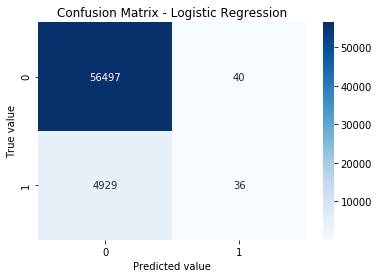

In [30]:
cmx = [[df_LR.iloc[0,1], df_LR.iloc[0,2]], [df_LR.iloc[0,3], df_LR.iloc[0,0]]]
ax = sns.heatmap(cmx , annot=True,fmt='d', cmap='Blues')

plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title('Confusion Matrix - Logistic Regression')

ax.set_ylim(2.0, 0) 
plt.show()

In [31]:
score_LR

,bin,score_min,score_max,bads,total,goods,bad_rate,bads_cum,goods_cum,total_cum,bads_cum_rate,goods_cum_rate,total_cum_rate,KS
0,"(-0.001, 7687.625]",0.154064,0.672522,1748,7688,5940,0.227367,1748,5940,7688,0.352064,0.105064,0.125004,0.247001
1,"(7687.625, 15375.25]",0.102452,0.154051,1035,7688,6653,0.134625,2783,12593,15376,0.560524,0.222739,0.250008,0.337785
2,"(15375.25, 23062.875]",0.075157,0.102446,731,7687,6956,0.095096,3514,19549,23063,0.707754,0.345774,0.374996,0.361981
3,"(23062.875, 30750.5]",0.057100,0.075156,495,7688,7193,0.064386,4009,26742,30751,0.807452,0.473000,0.500000,0.334452
4,"(30750.5, 38438.125]",0.043729,0.057098,368,7688,7320,0.047867,4377,34062,38439,0.881571,0.602473,0.625004,0.279098
5,"(38438.125, 46125.75]",0.032831,0.043729,291,7687,7396,0.037856,4668,41458,46126,0.940181,0.733290,0.749992,0.206892
6,"(46125.75, 53813.375]",0.022683,0.032829,186,7688,7502,0.024194,4854,48960,53814,0.977644,0.865982,0.874996,0.111662
7,"(53813.375, 61501.0]",0.001559,0.022682,111,7688,7577,0.014438,4965,56537,61502,1.000000,1.000000,1.000000,0.000000


K-S is a measure of the degree of separation between the positive and negative distributions.
After Logistic Regression with RFE model, Logistic Regression is the model that best separates default cases from non-default cases.

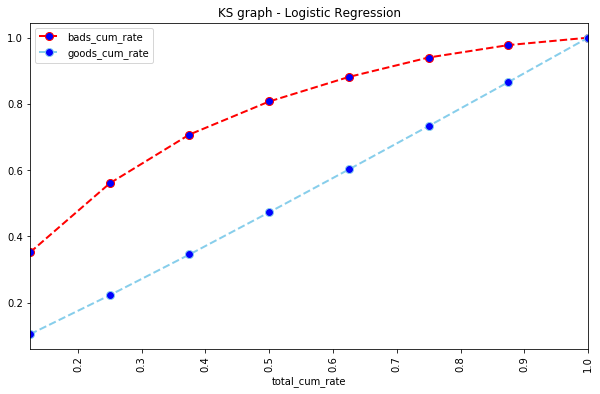

In [32]:
score_LR_plot = score_LR
score_LR_plot.plot(x = 'total_cum_rate',y= ['bads_cum_rate', 'goods_cum_rate'], 
              marker= 'o',
              markerfacecolor='blue', linestyle='dashed', markersize=8, 
              color=[ 'red','skyblue'], linewidth=2, figsize = (10,6), 
              title =  'KS graph - Logistic Regression', rot= 90)
plt.show()

The next chart shows the distribution of the positive (non-target) class.
It is possible to observe that the percentage of non-target cases over the total cases decreases as the predicted probability of default lowers. In other words, actual defaults are more associated with high scores (high probability of default) than with low scores.

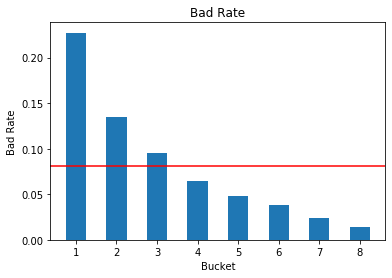

In [33]:
score_LR_plot['bucket']= score_LR_plot.index
score_LR_plot['bucket'] =score_LR_plot['bucket']+1

plt.bar(x = score_LR_plot['bucket'],height= score_LR_plot['bad_rate'], width=0.5, align='center')
plt.xlabel('Bucket', fontsize=10)
plt.ylabel('Bad Rate', fontsize=10)
plt.xticks(score_LR_plot['bucket'], label=score_LR_plot['bucket'], fontsize=10)
plt.axhline(score_LR_plot['bad_rate'].mean(), color='r')
plt.title('Bad Rate')
plt.show()